In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao

DESCOMPOSICIÓN Y BCD

In [ ]:
from src.agents.bcd import bcd

k = 10
scale = 100
num_iter = 100

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

Q = PARAFAC(
    np.concatenate(
        [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= scale,
    nA=len(discretizer.bucket_actions),
).double()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1





In [ ]:
bcd_inv = bcd(Q,Pi,discretizer,ENV,num_iter,k,Q_opt)

fo_values,errors,convs, Q = bcd_inv.run()

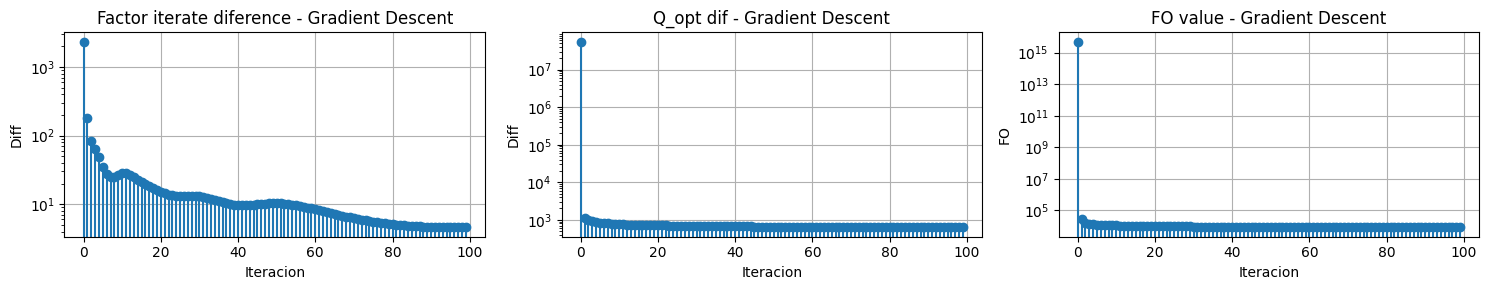

In [5]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

# Primer subplot: Seno
axes[0].stem(convs)
axes[0].set_title("Factor iterate diference - Gradient Descent")
axes[0].set_xlabel("Iteracion")
axes[0].set_ylabel("Diff")
axes[0].set_yscale('log')
axes[0].grid(True)

# Segundo subplot: Coseno
axes[1].stem(errors)
axes[1].set_title("Q_opt dif - Gradient Descent")
axes[1].set_xlabel("Iteracion")
axes[1].set_ylabel("Diff")
axes[1].set_yscale('log')
axes[1].grid(True)

# Tercer subplot: Tangente
axes[2].stem(fo_values)
axes[2].set_title("FO value - Gradient Descent")
axes[2].set_xlabel("Iteracion")
axes[2].set_ylabel("FO")
axes[2].set_yscale('log')
axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [5]:
from src.agents.bcd import bcgd

# GridWorld
k = 50
scale = 4
num_iter = 1000
alpha = 10e-6
use_q_qopt = False

ENV = GridWorldEnv()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = PARAFAC(
    np.concatenate(
        [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
    ),
    k=k,
    scale= scale,
    nA=len(discretizer.bucket_actions),
).double()

if use_q_qopt == True:
    new_values = parafac(Q_opt, rank=k)[1]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización direct
        i = 0
        for i in range(len(new_values)):
            shape = new_values[i].shape
            new_values[i] = new_values[i] + np.random.rand(*shape)*0.0001
            
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(torch.tensor(new_value))  # Copiar los nuevos valores al parámetro existente

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1


In [6]:

bcd_grad = bcgd(Q,Pi,discretizer,ENV,num_iter,k,Q_opt,alpha)

fo_values,errors,convs, Q = bcd_grad.run()

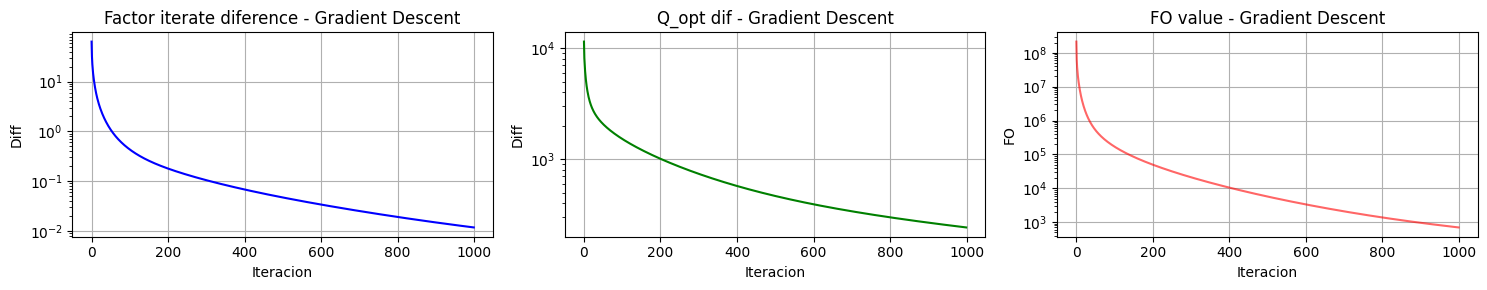

In [7]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

# Primer subplot: Seno
axes[0].plot(convs, label='Seno (sin)', color='blue')
axes[0].set_title("Factor iterate diference - Gradient Descent")
axes[0].set_xlabel("Iteracion")
axes[0].set_ylabel("Diff")
axes[0].set_yscale('log')
axes[0].grid(True)

# Segundo subplot: Coseno
axes[1].plot(errors, label='Coseno (cos)', color='green')
axes[1].set_title("Q_opt dif - Gradient Descent")
axes[1].set_xlabel("Iteracion")
axes[1].set_ylabel("Diff")
axes[1].set_yscale('log')
axes[1].grid(True)

# Tercer subplot: Tangente
axes[2].plot(fo_values, label='FO_S', color='red', alpha=0.6)
axes[2].set_title("FO value - Gradient Descent")
axes[2].set_xlabel("Iteracion")
axes[2].set_ylabel("FO")
axes[2].set_yscale('log')
axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [9]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh

new_values = parafac(Q_opt, rank=k)[1]
with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización directa
    for param, new_value in zip(Q.factors, new_values):
        param.copy_(torch.tensor(new_value))  # Copiar los nuevos valores al parámetro existente


H = Q.factors[0].detach().numpy()
A = Q.factors[1+len(discretizer.bucket_states):][0].detach().numpy()
S = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0].detach().numpy()

Ds = calculate_Ds(S, A, H, ENV, Pi)
Da = calculate_Da(S, A, H, ENV, Pi)
Dh = calculate_Dh(S, A, H, ENV, Pi, k)

print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Ds,(S).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,(A.T).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,(H).reshape(-1)),ord=2)**2)

3.0217524612541873e-21
2.9989233288768737e-21
3.0154377744091728e-21
